### Exploratory Data Analysis of Soarin' Wait Times

#### Overview and Considerations
In this notebook, we seek to perform an exploratory analysis of wait time data for the <i>Soarin'</i> attraction at Epcot. This will hopefully help to give us a qualitative sense of the relationship between wait times and other features, as well as bring any potential anomalies to our attention.

As our goal is to create a model that predicts future wait times for this attraction given these features, understanding relationships among features can help inform how we might construct this regression. This might include:

- Determining the amount of nulls within the data
- Determining the cardinality or variance of features, including possible outliers
- Determining correlation among features
- Understanding if a relationship between two features is linear/nonlinear (if such a relationship exists)

For a model like this to be used, we would need to be able to collect all required features at runtime, and the distribution of future observations would need to be as close as possible to those used in development. Given global affairs involving Covid-19 and related economic repercussions, it is unknown if this would be a fair assumption in the months years ahead.

While we might expect some new factors such as reduced park hours to return to normal at some point in 2021, we would probably want to pay close attention to other how other features are affected going forward. For instance, this analysis will incorporate economic indicators such as unemployment and Consumer Price Index which have been affected by the pandemic (and may continue to be after the pandemic ends).

Although this project is more academic in nature as opposed to creating a fully in-production data product, it is important to keep these considerations in mind to ensure that anything we build here can be used in the future.

#### Load modeling dataset from sqlite3

In [1]:
# Packages
import numpy as np
import pandas as pd
import sqlite3
import plotly.express as px

In [2]:
# Pull Soarnin' data
with open('../src/soarin_query.sql', 'r') as sqlfile:
    soarin_query = sqlfile.read()

with sqlite3.connect('../data/project_data.db') as conn:
    soarin_df = pd.read_sql(soarin_query, con=conn)

#### Training fold
The proposed modeling method will have a simplistic train/dev/test split in which training will be done on years 2015-2017. Data from 2018 will be used as a validation/dev set and 2019 will be used for testing. Given this method, exploratory analysis will be limited to 2015-2017 only in order to limit leakage of information from the dev/test sets into the training process.

This gives us approximately 120,000 records for training, with validation and testing having ~45,000 records each.

In [3]:
# Subset data to only include what will become the training set
train_df = soarin_df[soarin_df.year_of_calendar.isin([2015,2016,2017])].reset_index(drop=True)

In [4]:
# View the first 5 rows
train_df.head()

,date_id,year_of_calendar,month_of_year,day_of_month,day_of_week,hour_of_day,minute_of_day,tmax,holiday_ind,days_tofrom_holiday,unemp_local_change,unemp_natl_change,cpi_natl_change,avg_wait_time_prev,wait_time
0,2015-01-08,2015,1,8,3,8,56,62.0,0,NaN,0.2,0.2,0.598,30.625,10.0
1,2015-01-08,2015,1,8,3,9,0,62.0,0,NaN,0.2,0.2,0.598,57.333,10.0
2,2015-01-08,2015,1,8,3,9,7,62.0,0,NaN,0.2,0.2,0.598,57.333,10.0
3,2015-01-08,2015,1,8,3,9,14,62.0,0,NaN,0.2,0.2,0.598,57.333,10.0
4,2015-01-08,2015,1,8,3,9,21,62.0,0,NaN,0.2,0.2,0.598,57.333,15.0


In [39]:
train_df.shape

(123786, 15)

In [40]:
soarin_df[soarin_df.year_of_calendar==2018].shape

(47603, 15)

In [41]:
soarin_df[soarin_df.year_of_calendar==2019].shape

(42249, 15)

#### Metadata
The raw dataset from our SQL query consists of 15 columns (not all of which may be used for attempting to build a model). A brief data dictionary is provided here:

- <b>date_id (date)</b>: The date of the observation

- <b>year_of_calendar (int)</b> : The year of the observation

- <b>month_of_year (int)</b>: The month of the observation

- <b>day_of_month (int)</b>: The day of the month

- <b>day_of_week (int)</b>: The day of the week (ex. 0 = Monday, 6 = Sunday)

- <b>hour_of_day (int)</b>: The hour of the day (0-23)

- <b>minute_of_day (int)</b>: The minute of the current hour

- <b>tmax (real)</b>: The high temperature measured at Orlando International Airport for the day (at runtime, this would need to be substituted by a forecast)

- <b>holiday_ind (int 0-1)</b>: Indicates if the current day is a federal holiday

- <b>days_tofrom_holiday (int -5 to 5)</b>: If the current day is within 5 days of a holiday, gives the number of days until the holiday (ex. -2 is two days before a holiday, 3 is three days after a holiday)

- <b>unemp_local_change (real)</b>: This is the difference between the monthly Orlando area unemployment rate measured 4 months and 3 months prior to the record (anything more recent may not be available at runtime)

- <b>unemp_natl_change (real)</b>: This is the difference between the national unemployment rate measured 4 months and 3 months prior to the record (anything more recent may not be available at runtime)

- <b>cpi_ntal_change (real)</b>: This is the difference between the national Consumer Price Index measured 4 months and 3 months prior to the record (anything more recent may not be available at runtime)

- <b>avg_wait_time_prev (real)</b>: This is the average wait time as measured over the span of the same hour for the week prior to the record

- <b>wait_time (real)</b>: The recorded wait time in minutes

#### Descriptive Statistics
We can view a high level distribution of our dataset and take note of any items that may influence our analysis. 

Most columns are entirely non-null with two exceptions. There is a large null rate for the number of days to the neartest holiday feature, but this is expected as any measure date must be within 5 days of a holiday for this to be populated. There is also a small null percentage in the week lagged wait times in which there was not a wait time measurement for that hour in the prior week.

In [5]:
# Describe df
train_df.describe()

,year_of_calendar,month_of_year,day_of_month,day_of_week,hour_of_day,minute_of_day,tmax,holiday_ind,days_tofrom_holiday,unemp_local_change,unemp_natl_change,cpi_natl_change,avg_wait_time_prev,wait_time
count,123786.00000,123786.000000,123786.000000,123786.000000,123786.000000,123786.000000,123786.000000,123786.000000,42860.000000,123786.000000,123786.000000,123786.000000,119918.000000,123786.000000
mean,2015.97427,7.173493,15.930541,2.971216,14.447466,28.778497,85.072108,0.031587,-0.044797,0.062846,0.076211,-0.316495,54.735964,55.858643
std,0.87955,3.400230,8.919475,1.985797,3.881064,17.990899,8.139391,0.174898,3.140154,0.230183,0.303272,0.760753,26.993424,30.703146
min,2015.00000,1.000000,1.000000,0.000000,0.000000,0.000000,52.000000,0.000000,-5.000000,-0.500000,-0.700000,-1.407000,5.000000,0.000000
25%,2015.00000,5.000000,8.000000,1.000000,11.000000,15.000000,81.000000,0.000000,-3.000000,0.000000,-0.100000,-0.968000,37.222000,35.000000
50%,2016.00000,7.000000,16.000000,3.000000,14.000000,28.000000,87.000000,0.000000,0.000000,0.100000,0.100000,-0.480000,51.667000,50.000000
75%,2017.00000,10.000000,24.000000,5.000000,18.000000,43.000000,91.000000,0.000000,3.000000,0.200000,0.300000,0.169000,68.750000,70.000000
max,2017.00000,12.000000,31.000000,6.000000,23.000000,59.000000,100.000000,1.000000,5.000000,0.500000,0.500000,1.339000,210.000000,240.000000


In [10]:
# Null percentage
train_df.apply(lambda x:pd.isnull(x).sum())/train_df.shape[0]*100

date_id                 0.000000
year_of_calendar        0.000000
month_of_year           0.000000
day_of_month            0.000000
day_of_week             0.000000
hour_of_day             0.000000
minute_of_day           0.000000
tmax                    0.000000
holiday_ind             0.000000
days_tofrom_holiday    65.375729
unemp_local_change      0.000000
unemp_natl_change       0.000000
cpi_natl_change         0.000000
avg_wait_time_prev      3.124748
wait_time               0.000000
dtype: float64

We can also take note of some of the features obtained from the Bureau of Labor Statistics. Given that unemployment had been steadily falling over this timeframe and is only tracked to one significant digit, it is perhaps not surprising that we do not see many distinct values for the change these features. CPI changes on the other hand are more continuous.

In [11]:
# Distinct values in lagged monthly changes in labor statistics
train_df[['unemp_local_change','unemp_natl_change','cpi_natl_change']] \
.nunique()

unemp_local_change    10
unemp_natl_change     11
cpi_natl_change       33
dtype: int64

#### Wait Time Summary
Overall, we can see that wait time measurements exhibited a skewed distribution from 2015-2017. The median wait time was approximately 50 minutes, though we can see on rare occasions wait times reached 3-4 hours.

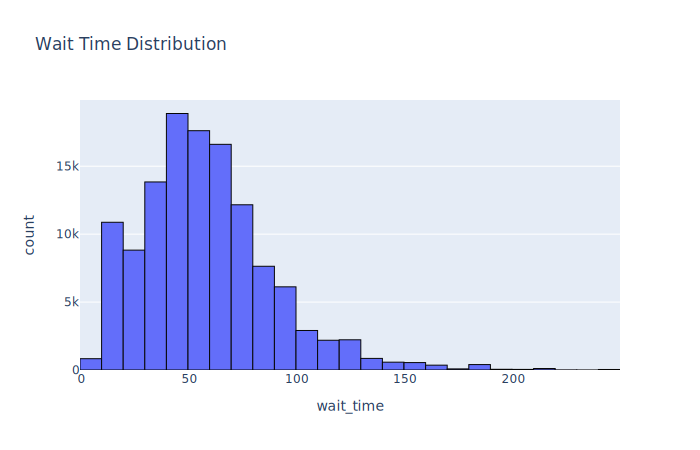

In [12]:
# Wait time distribution
fig = px.histogram(data_frame=train_df, x='wait_time', nbins=30, title='Wait Time Distribution')
fig.update_traces(marker_line_color='rgb(5,5,5)', marker_line_width=1)
fig.show('svg')

In [13]:
# Quantiles
train_df.wait_time.quantile([i/10 for i in range(11)])

0.0      0.0
0.1     20.0
0.2     30.0
0.3     40.0
0.4     45.0
0.5     50.0
0.6     60.0
0.7     65.0
0.8     75.0
0.9     95.0
1.0    240.0
Name: wait_time, dtype: float64

#### Relationships Between Wait Time and Training Features

##### Correlation/Linear relationships

Plotting correlations of the inputs to the wait time, we perhaps unsurprisingly see the week-lagged wait time exhibiting the largest value, with some weaker effects from the unemployment and CPI features.

It is possible that other features (such as time of day, month, etc.) do have some relationship to the wait time, but these relationships may not necessarily be linear.

In [14]:
# Correlations to target
train_df.drop('year_of_calendar', axis=1).corr().wait_time.sort_values()

tmax                  -0.087914
hour_of_day           -0.057808
days_tofrom_holiday   -0.034803
minute_of_day         -0.005213
month_of_year         -0.000653
day_of_week            0.005490
holiday_ind            0.063500
unemp_natl_change      0.098263
cpi_natl_change        0.099102
day_of_month           0.107547
unemp_local_change     0.145756
avg_wait_time_prev     0.480539
wait_time              1.000000
Name: wait_time, dtype: float64

##### Month of year

Looking at average wait times by month, we can see that wait times drop quite noticeably around September before climbing sharply at the end of the year.

In [15]:
def quick_wait_time_agg(feature):
    # Helper function to show the wait time mean grouped by an input feature
    context = train_df \
    .groupby(feature, as_index=False) \
    .agg({'wait_time':'mean'})
    return context

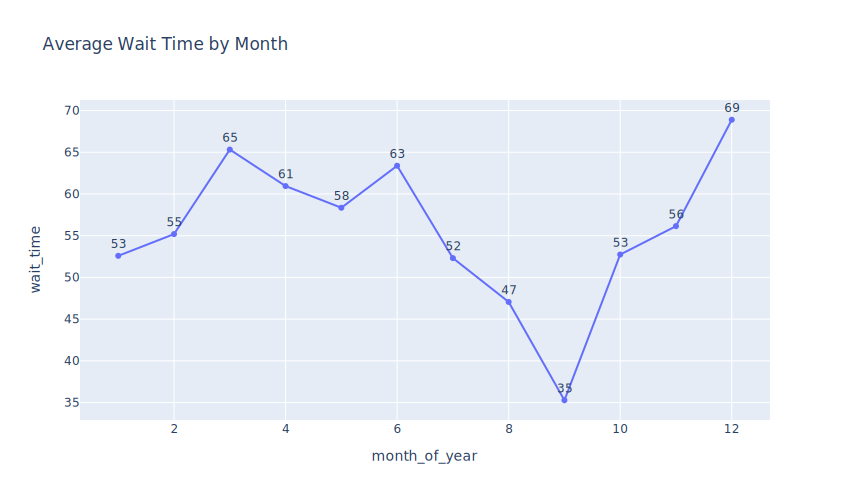

In [16]:
# Month of year
context = quick_wait_time_agg('month_of_year')
fig = px.line(data_frame=context, x='month_of_year', y='wait_time', title='Average Wait Time by Month',
              text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

##### Day of Week

We also see slight decreases in wait times in the middle of the week around Wednesdays and Thursdays on average.

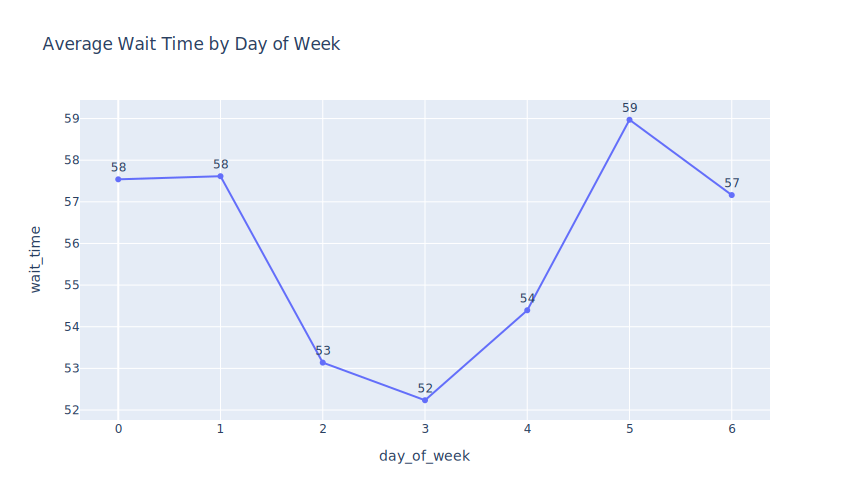

In [17]:
# Day of week
context = quick_wait_time_agg('day_of_week')
fig = px.line(data_frame=context, x='day_of_week', y='wait_time', title='Average Wait Time by Day of Week',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

##### Time of Day

If we view average wait times by hour of the day, we can see some observations occurring very early in the day. Checking counts, we can see these observations are sparse and may be due to special events (ex. New Year's).

Continuing into more regular operating hours, we can see wait times climb to higher levels as the day progresses, then begin to fall in the evening hours.

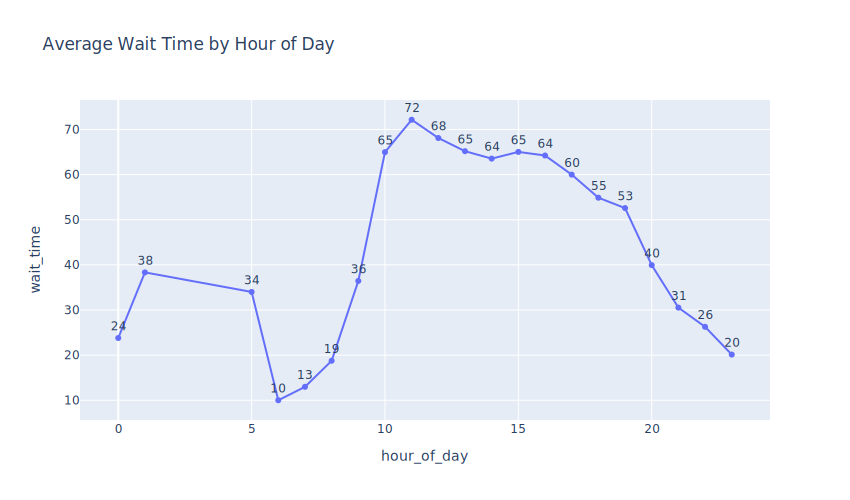

In [18]:
# Hour of day
context = quick_wait_time_agg('hour_of_day')
fig = px.line(data_frame=context, x='hour_of_day', y='wait_time', title='Average Wait Time by Hour of Day',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

In [19]:
# Observation count by hour of day
train_df.groupby('hour_of_day').agg({'wait_time':'count'})

,wait_time
hour_of_day,
0,58
1,3
5,1
6,12
7,419
8,3713
9,11489
10,10040
11,9351


We can also attempt to visualize wait times by time of day by converting the hour and minute columns into a single more continuous feature. If we choose to limit our analysis to wait times from 7am onwards, we can see a rough parabolic relationship, with more extreme observations occurring between noon and the early evening.

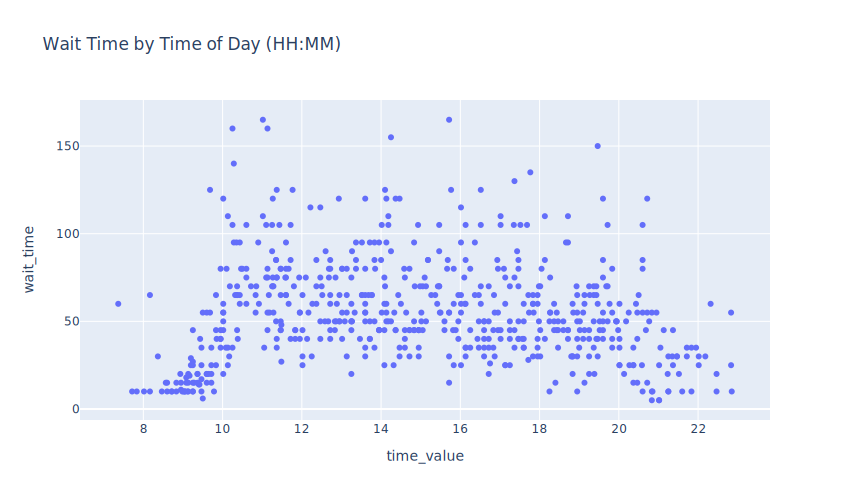

In [20]:
# Time of day (continuous scatter)
context = train_df[train_df.hour_of_day >= 7] \
.assign(time_value = lambda x: x.hour_of_day + x.minute_of_day/60)[['time_value','wait_time']] \
.sample(600)

fig = px.scatter(data_frame = context, x='time_value', y='wait_time', title='Wait Time by Time of Day (HH:MM)')
fig.show('svg', width=850, height=500)

One thing we might consider in this case would be to view how polynomial transforms might affect this relationship. For instance, we could create a parabolic function of the current time, centered at some point in the day. In this example, we can start to see a more linear relationship develop.

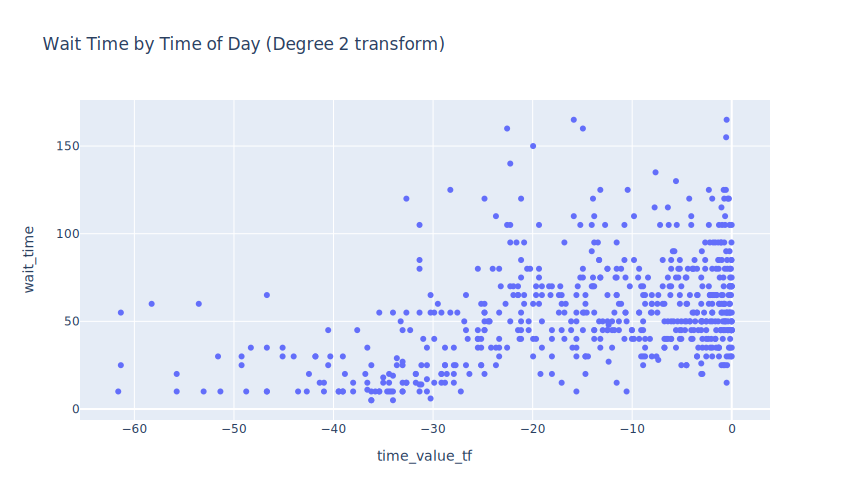

In [21]:
# Degree 2 transformation
context['time_value_tf'] = -(context.time_value-15)**2
fig = px.scatter(data_frame = context, x='time_value_tf', y='wait_time', title='Wait Time by Time of Day (Degree 2 transform)')
fig.show('svg', width=850, height=500)

We could explore even further to try to capture the "skew" in the parabola seen in the average wait time by hour of day (ex. using higher power function transforms). This could introduce some degree of overfitting however, so we could experiment with this through validation methods.

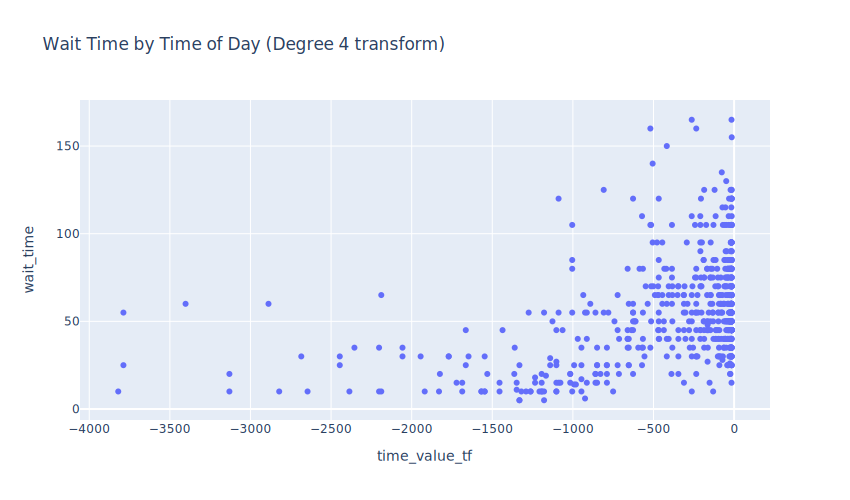

In [22]:
# Degree 4 transformation
context['time_value_tf'] = -((context.time_value-15)**4 + context.time_value)
fig = px.scatter(data_frame = context, x='time_value_tf', y='wait_time', title='Wait Time by Time of Day (Degree 4 transform)')
fig.show('svg', width=850, height=500)

##### Daily High Temperature

If we bin daily high temperatures by rounding to the nearest 10 degrees F, we can see a loose inverse relationship. The higher wait times associated with temperatures in the 50-60 F range may be correlated to the time of year (where the park is possibly more busy due to the holiday season).

As we might expect, observed high temperatures in the 50F range are quite low in count compared to the other bins (this would be a fairly low temperature for central Florida).

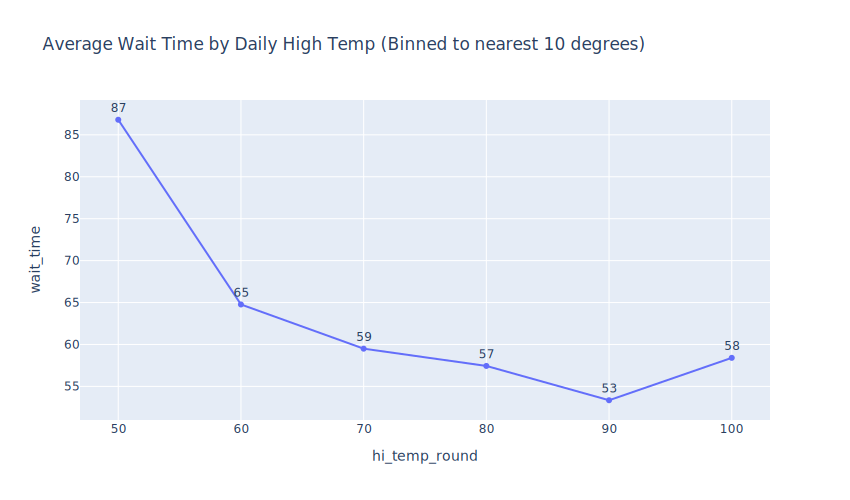

In [23]:
# Daily high temperature
context = train_df \
.assign(hi_temp_round=round(train_df.tmax,-1)) \
.groupby('hi_temp_round', as_index=False) \
.agg({'wait_time':'mean', 'tmax':'count'})
context.columns = ['hi_temp_round','wait_time','row_count']

fig = px.line(data_frame=context, x='hi_temp_round', y='wait_time', 
              title='Average Wait Time by Daily High Temp (Binned to nearest 10 degrees)',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

In [24]:
# View counts for temperature bins
context

,hi_temp_round,wait_time,row_count
0,50.0,86.800000,150
1,60.0,64.768085,4230
2,70.0,59.496979,8773
3,80.0,57.437443,40915
4,90.0,53.345036,62521
5,100.0,58.402668,7197


##### Holidays
It is reasonable to expect that attendance (and thus wait times) will be higher on a national holiday, but we also might want to consider the days leading up to and the days following a holiday.

While wait times are elevated on holidays, we can actually see that wait times are even higher on the two days prior.

This analysis only considers days 5 days before or after the holiday - we can see that measurements outside this range have lower wait times on average.

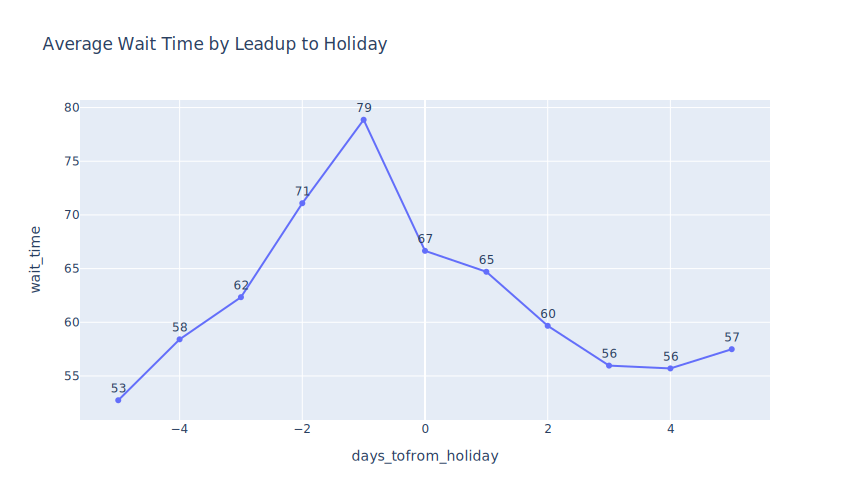

In [26]:
# Holidays
context = quick_wait_time_agg('days_tofrom_holiday')
fig = px.line(data_frame=context, x='days_tofrom_holiday', y='wait_time', title='Average Wait Time by Leadup to Holiday',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

In [28]:
# Other days outside this range see shorter times on average
round(train_df[pd.isnull(train_df.days_tofrom_holiday)].wait_time.mean(),2)

52.47

##### Unemployment Rate (local and national)
Both unemployment measures cover a fairly small range describing monthly percent change (and it is unclear if this range will be representative of future years from 2021 and beyond). Both measures exhibit a weak positive correlation with wait times, but it remains to be seen if this will generalize to unseen data.

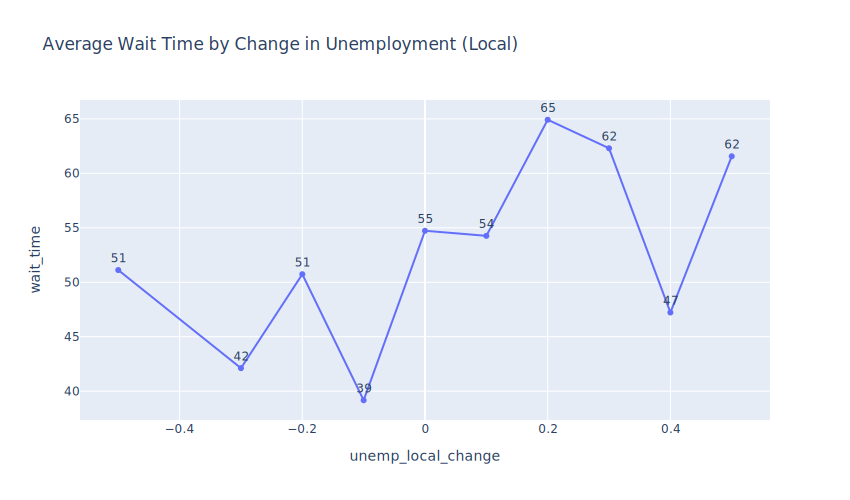

In [31]:
# Local unemployment
context = quick_wait_time_agg('unemp_local_change')
fig = px.line(data_frame=context, x='unemp_local_change', y='wait_time', title='Average Wait Time by Change in Unemployment (Local)',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

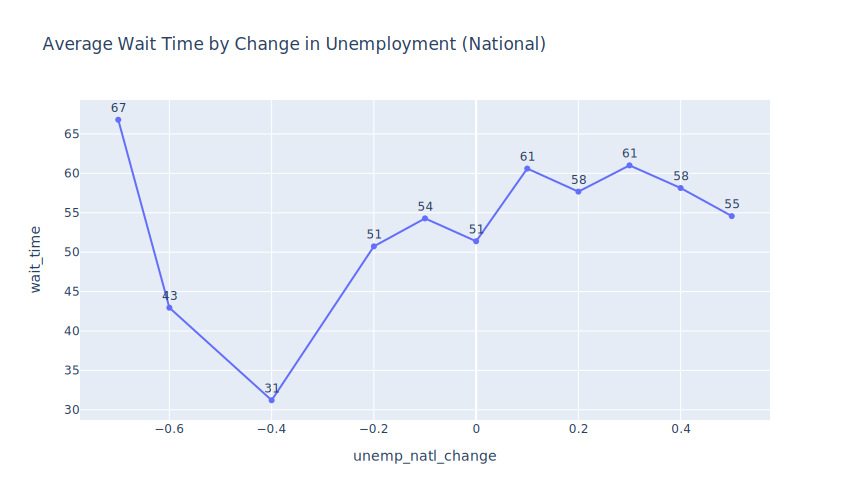

In [32]:
# National unemployment
context = quick_wait_time_agg('unemp_natl_change')
fig = px.line(data_frame=context, x='unemp_natl_change', y='wait_time', title='Average Wait Time by Change in Unemployment (National)',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

##### Consumer Price Index
As noted previously, CPI changes also have a low positive correlation with wait time. If we visualize this by binning CPI changes to the nearest 0.1 and look at mean values, we can see some evidence of this small correlation.

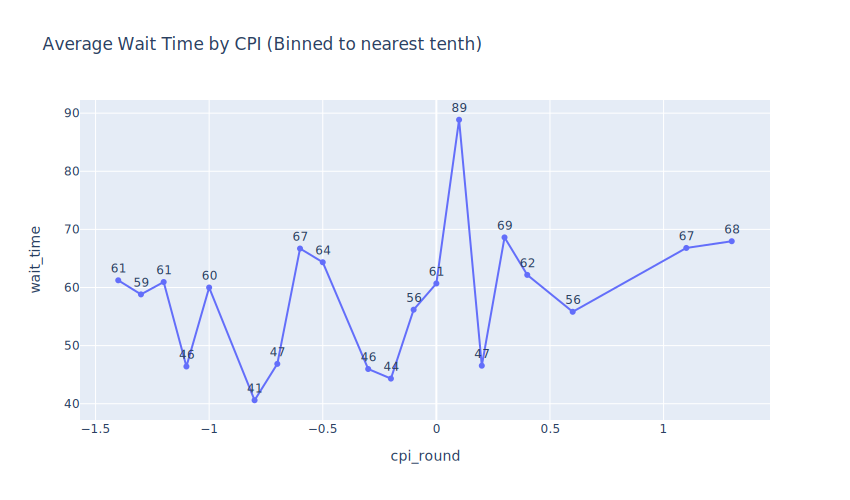

In [37]:
# CPI
context = train_df \
.assign(cpi_round=round(train_df.cpi_natl_change,1)) \
.groupby('cpi_round', as_index=False) \
.agg({'wait_time':'mean', 'tmax':'count'})
context.columns = ['cpi_round','wait_time','row_count']

fig = px.line(data_frame=context, x='cpi_round', y='wait_time', 
              title='Average Wait Time by CPI (Binned to nearest tenth)',
             text=round(context.wait_time,0))
fig.data[0].update(mode='markers+lines+text')
fig.update_traces(textposition='top center')
fig.show('svg', width=850, height=500)

##### Previous Average Wait Times (one week prior, averaged over the hour)
As we might expect and as noted earlier, this feature has one of the highest positive correlations to measured wait times prior to any transforms or adjustments, though unusual cases do exist in the form of large week to week increases/drop-offs. 

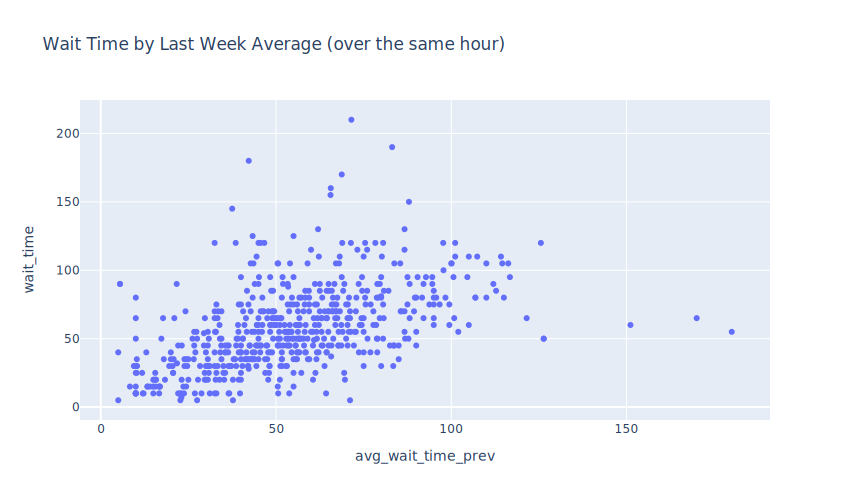

In [38]:
# Wait times from prior week
context = train_df.sample(600)
fig = px.scatter(data_frame = context, x='avg_wait_time_prev', y='wait_time', title='Wait Time by Last Week Average (over the same hour)')
fig.show('svg', width=850, height=500)

#### Next Steps
We have qualitatively shown that the covariate features, at least in part, may be correlated <i>Soarin'</i> wait times. Given this information, we can then proceed to incorporating these features into a model that attempts to predict the expected wait time for this attraction at a given time. Proposed model hypotheses can be tuned on a validation/dev set using 2018 data, and final model performance can be estimated with a holdout set from 2019.